In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '14/06/2021'
id_noticia = '261947'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'
dias_grafico = 180

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[len(tables) - 1] # Last table

In [6]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha

for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0].str.replace('*', '')

dfL

# El dato oficial de PCR Positivo de Huelva es 32.106, no 31.106
# En los cálculos diarios se usa el oficial

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,55.021,3.881,668,835,53.788,14/06/2021
1,Cádiz,83.261,5.757,653,1.494,79.243,14/06/2021
2,Córdoba,53.875,4.572,571,966,51.072,14/06/2021
3,Granada,89.423,8.179,1.079,1.772,85.244,14/06/2021
4,Huelva,32.482,2.316,167,386,30.170,14/06/2021
5,Jaén,50.777,4.663,445,994,48.413,14/06/2021
6,Málaga,102.751,8.224,787,1.657,98.935,14/06/2021
7,Sevilla,132.742,10.774,1.088,2.016,124.630,14/06/2021
8,Total,600.332,48.366,5.458,10.120,571.495,14/06/2021


In [7]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [8]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [9]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [10]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [11]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [12]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [13]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2021-06-14,77.0,0.0,0.0,66.0,0.0
Cádiz,2021-06-14,316.0,0.0,2.0,182.0,0.0
Córdoba,2021-06-14,183.0,1.0,13.0,147.0,0.0
Granada,2021-06-14,601.0,1.0,3.0,176.0,1.0
Huelva,2021-06-14,150.0,0.0,3.0,162.0,0.0
Jaén,2021-06-14,204.0,0.0,0.0,106.0,0.0
Málaga,2021-06-14,435.0,0.0,11.0,242.0,0.0
Sevilla,2021-06-14,1033.0,0.0,2.0,234.0,0.0
Total,2021-06-14,2999.0,2.0,34.0,1315.0,1.0


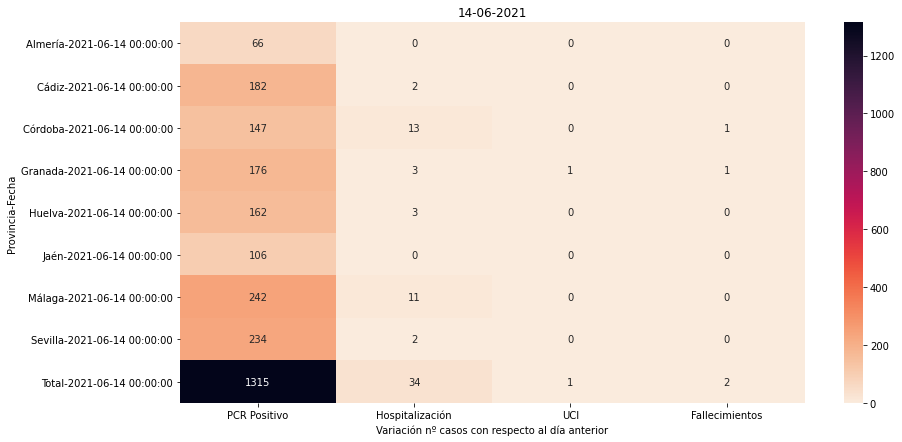

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('Variación nº casos con respecto al día anterior')
plt.show()

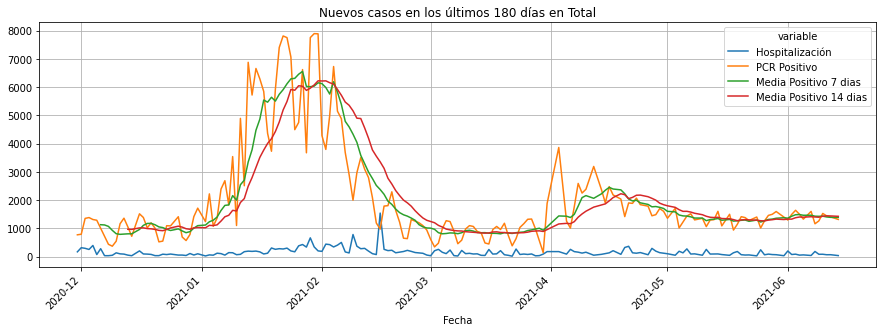

In [15]:
DrawMediaFlotante(df, 'Total', dias_grafico)

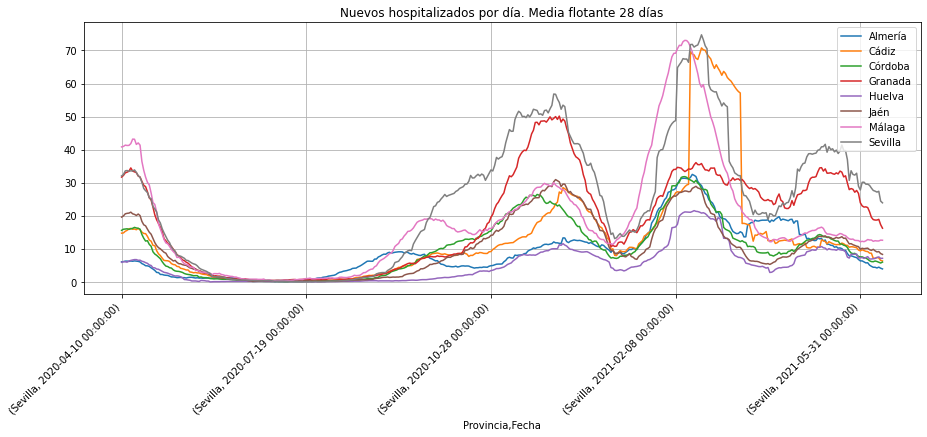

In [16]:
dias = 28
data = dfV['Hospitalización'].rolling(window=dias).mean().dropna().drop('Total')
data.groupby('Provincia').plot(title='Nuevos hospitalizados por día. Media flotante ' + str(dias) + ' días', figsize=(15,5), grid=True,legend=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [17]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Hospitalización'], ascending=[False, True])

variable,Fecha,Hospitalización,dias
Provincia,,,
Almería,2021-06-12,3.0,2 days
Jaén,2021-06-12,4.0,2 days
Sevilla,2021-06-14,2.0,0 days
Cádiz,2021-06-14,2.0,0 days
Huelva,2021-06-14,3.0,0 days
Granada,2021-06-14,3.0,0 days
Málaga,2021-06-14,11.0,0 days
Córdoba,2021-06-14,13.0,0 days
Total,2021-06-14,34.0,0 days


In [18]:
# Positivos por cada Hospitalización
dfG['PCR Positivo']/dfG['Hospitalización']

Provincia  Fecha     
Almería    2021-06-14           inf
Cádiz      2021-06-14     91.000000
Córdoba    2021-06-14     11.307692
Granada    2021-06-14     58.666667
Huelva     2021-06-14     54.000000
Jaén       2021-06-14           inf
Málaga     2021-06-14     22.000000
Sevilla    2021-06-14    117.000000
Total      2021-06-14     38.676471
dtype: float64

In [19]:
# Fecha de último ingreso en UCI
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'UCI'], ascending=[False, True])

variable,Fecha,UCI,dias
Provincia,,,
Jaén,2021-06-10,1.0,4 days
Málaga,2021-06-10,3.0,4 days
Sevilla,2021-06-10,5.0,4 days
Cádiz,2021-06-10,5.0,4 days
Huelva,2021-06-11,1.0,3 days
Córdoba,2021-06-11,1.0,3 days
Almería,2021-06-11,1.0,3 days
Total,2021-06-14,1.0,0 days
Granada,2021-06-14,1.0,0 days


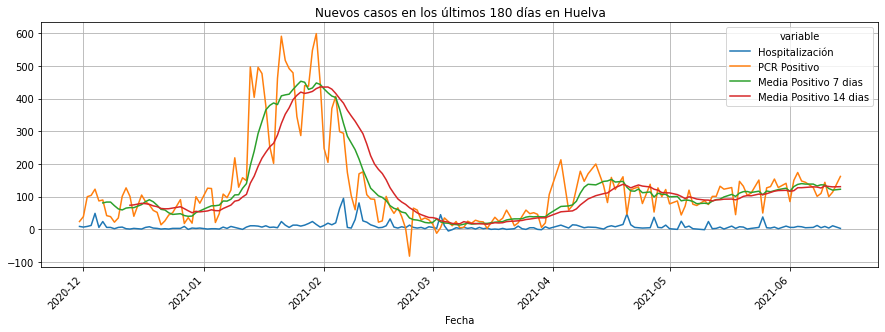

In [20]:
DrawMediaFlotante(df, 'Huelva', dias_grafico)

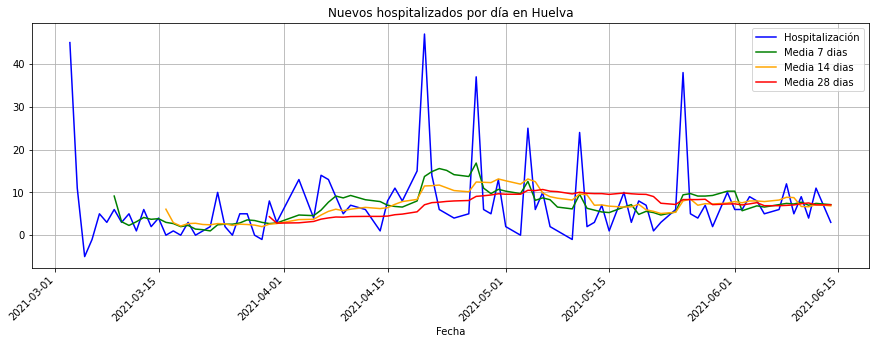

In [21]:
data = pd.DataFrame(dfV.loc['Huelva']['Hospitalización'].tail(90).copy())
data.columns = ['Hospitalización']
data['Media 7 dias'] = data['Hospitalización'].rolling(window=7).mean()
data['Media 14 dias'] = data['Hospitalización'].rolling(window=14).mean()
data['Media 28 dias'] = data['Hospitalización'].rolling(window=28).mean()
data.plot(title='Nuevos hospitalizados por día en Huelva', figsize=(15,5), grid=True, color = ['blue', 'green', 'orange', 'red'])
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

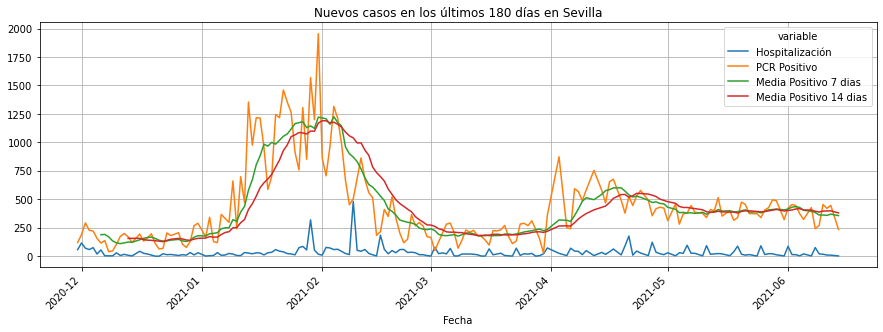

In [22]:
DrawMediaFlotante(df, 'Sevilla', dias_grafico)

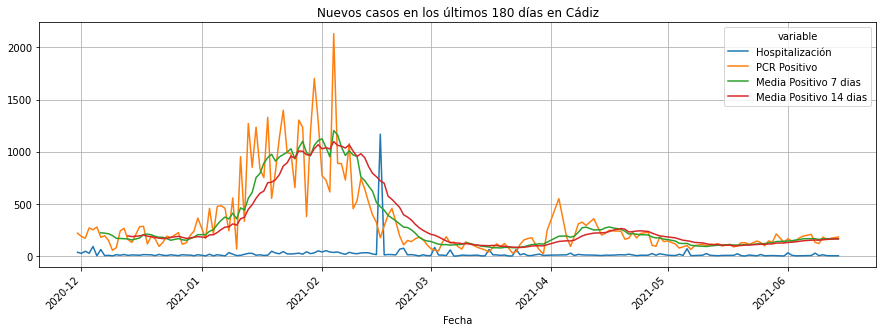

In [23]:
DrawMediaFlotante(df, 'Cádiz', dias_grafico)

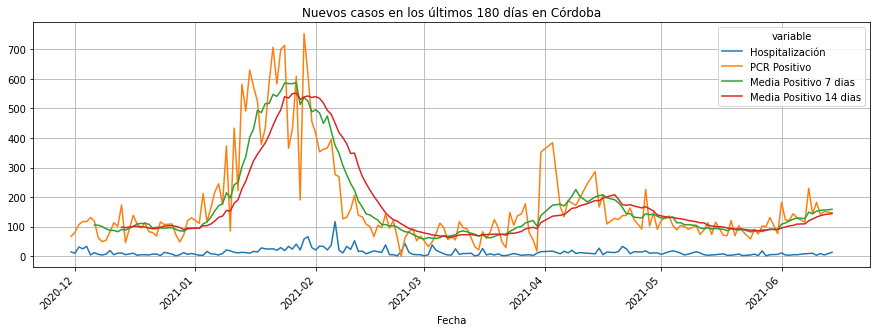

In [24]:
DrawMediaFlotante(df, 'Córdoba', dias_grafico)

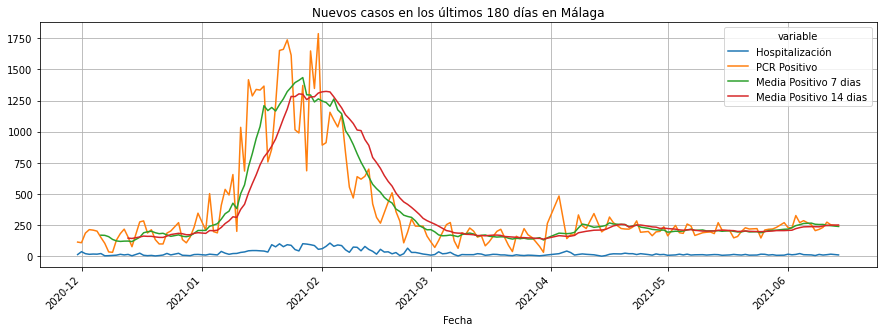

In [25]:
DrawMediaFlotante(df, 'Málaga', dias_grafico)

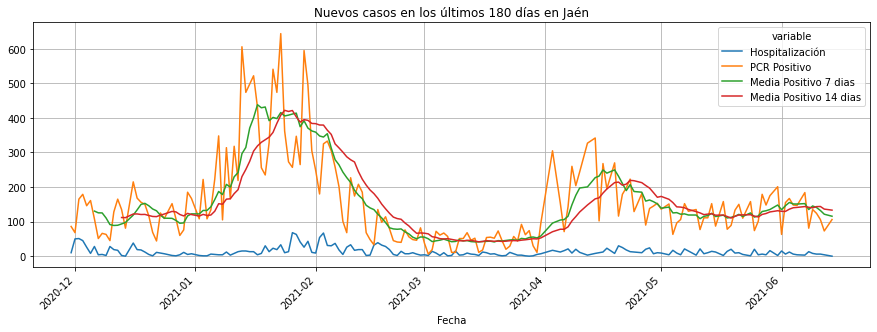

In [26]:
DrawMediaFlotante(df, 'Jaén', dias_grafico)

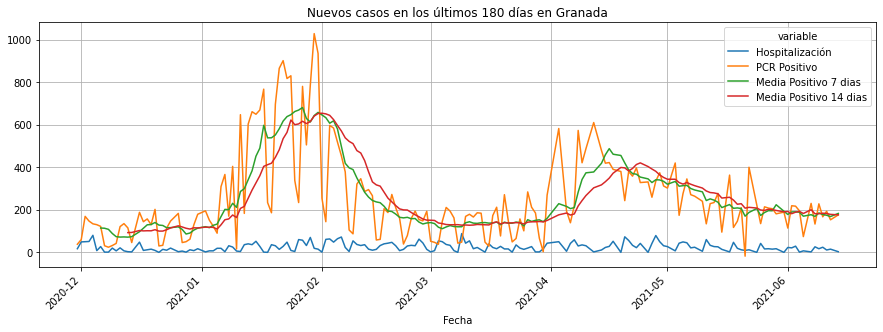

In [27]:
DrawMediaFlotante(df, 'Granada', dias_grafico)

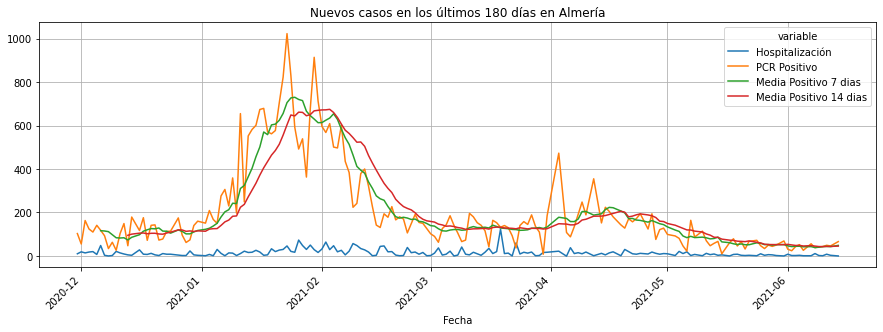

In [28]:
DrawMediaFlotante(df, 'Almería', dias_grafico)